## Make Allan Deviation Plot

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import allantools

from andbro__querrySeismoData import __querrySeismoData
from andbro__read_sds import __read_sds

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [3]:
## Configurations

config = {}

config['tbeg'] = obs.UTCDateTime("2023-06-05 17:00")
config['tend'] = obs.UTCDateTime("2023-06-06 00:00")

config['tbeg'] = obs.UTCDateTime("2023-06-08 00:00")
config['tend'] = obs.UTCDateTime("2023-06-08 11:00")
config['tend'] = obs.UTCDateTime("2023-06-08 01:00")

# config['tbeg'] = obs.UTCDateTime("2023-06-04 17:00")
# config['tend'] = obs.UTCDateTime("2023-06-04 20:30")

# config['seed'] = "BW.ROMY..FJV"
config['seed'] = "BW.ROMY.10.BJZ"

config['repository'] = "archive"

# config['output_figures'] = root_path+"Documents/LMU_Docs/GRM2023/Poster/"

# config['outpath'] = f''
# config['outfile'] = f''
# config['outfigs'] = f''

config['net'], config['sta'], config['loc'], config['cha'] = config['seed'].split(".")

## ALLAN

## show error bars
config['errorbars'] = True

## plot rotation rate relative to 2pi/86400
config['relative'] = False

## tau interval
config['tau'] = 'all' ## all, octave, decade

## type of allan deviation
config['method'] = 'adev' ## adev, oadev, mdev

## Load Data

### import raw sagnac data

In [ ]:
# st = __read_sds(archive_path+"romy_archive", "BW.DROMY..FJZ", config['tbeg'], config['tend'])

# for tr in st:
    
#     tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]
    
#     tr.data = tr.data/10182093.88
    
# st

### import sagnac frequency

In [68]:
# !ls /home/andbro/kilauea-data/sagnac_frequency/autodata/

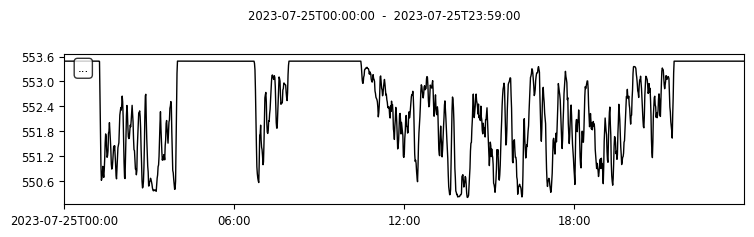

In [113]:
from pandas import read_pickle

data = read_pickle("/home/andbro/kilauea-data/sagnac_frequency/autodata/FJZ_20230725.pkl")

tr = obs.Trace()
tr.data = np.array(data.fz)
tr.stats.delta = 60
tr.stats.starttime = obs.UTCDateTime("2023-07-25 00:00")
st = obs.Stream(tr)

st.plot();

In [78]:
## convert from Hz to rad/s with scale factor
st[0].data /= 10182093.88

## select time period
st.trim(obs.UTCDateTime("2023-07-25 11:00"), obs.UTCDateTime("2023-07-25 20:00"))

## remove trend
st.detrend("simple")

st.plot();

1 Trace(s) in Stream:
... | 2023-07-25T11:00:00.000000Z - 2023-07-25T20:00:00.000000Z | 60.0 s, 541 samples

### import rotation rate data

In [ ]:
# st, inv = __querrySeismoData(    
#                             seed_id=config['seed'],
#                             starttime=config['tbeg']-10,
#                             endtime=config['tend']+10,
#                             repository=config['repository'],
#                             path=None,
#                             restitute=False,
#                             detail=None,
#                             fill_value=None,
# )

# st.detrend("demean")

# st.remove_sensitivity(inv)

# st.trim(config['tbeg'], config['tend'])

### import sagnac frequency data

In [ ]:
# from pandas import read_pickle
# from andbro__convert_to_stream import __convert_to_stream

# df = read_pickle("/import/kilauea-data/sagnac_frequency/autodata/FJZ_20230606.pkl")

# st = __convert_to_stream(df['fz'], starttime='2023-06-06 00:00:00', sampling_rate=1/60,  seed='XX.Test..ccc')

# t1 = obs.UTCDateTime("2023-06-06 00:00")
# t2 = obs.UTCDateTime("2023-06-06 04:30")

# st.trim(t1, t2)

# st.detrend("simple")

In [ ]:
st.plot();

## Compute Allan Dev

In [99]:
## define tau range e.g. 5 (= 10⁵) and number of samples N
upper = 6
lower = -4
N = 100

## list of tau values in seconds
taux = np.logspace(lower, upper, N)

## smallest sampling in seconds
dtaux = taux[1]-taux[0]

## sampling rate
df = st[0].stats.sampling_rate

In [100]:
# allan = allantools.tdev( st[0].data, 
#                          data_type='freq', 
#                          rate=df, 
#                          taus=config['tau'] 
#                         )

In [107]:
## normal allan deviation
## allan = (taus1, adevs1, errors, ns) 

if config['method'] == "oadev":
    allan = allantools.oadev(st[0].data, 
                             data_type='freq', 
                             rate=df, 
                             taus=config['tau'],
                             )    

elif config['method'] == "mdev":
    allan = allantools.mdev(st[0].data, 
                            data_type='freq', 
                            rate=df, 
                            taus=config['tau'],
                            )    
    
elif config['method'] == "adev":
    allan = allantools.adev(st[0].data, 
                            data_type='freq', 
                            rate=df, 
                            taus=config['tau'],
                            )

## Plotting

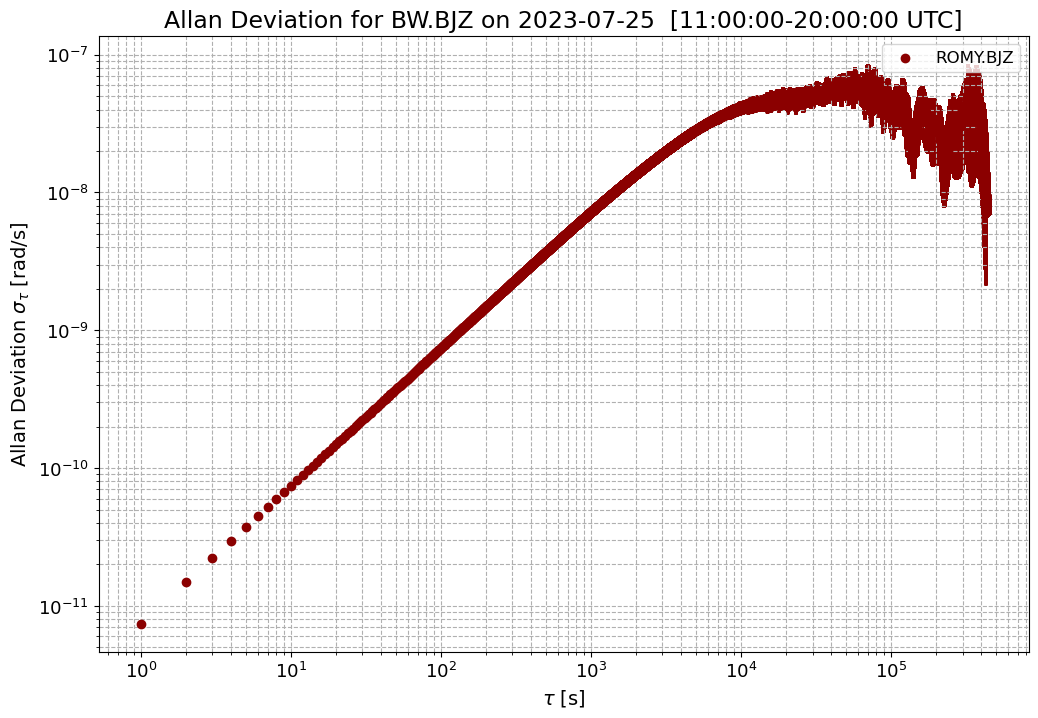

In [108]:
def __makeplot_allan_deviation(config, st, allan):

    taus, adev, errors, ns = allan[0], allan[1], allan[2], allan[3]

    day = st[0].stats.starttime.date
    tt1 = str(st[0].stats.starttime.time)[:8]
    tt2 = str(st[0].stats.endtime.time)[:8]  
    
    if config['relative']:
        adev = adev / 7.3e-5
        
    ## -------------------------------------------
    fig, ax = plt.subplots(1,1, figsize=(12,8))

    font = 14


    if config['errorbars']:
        ax.scatter(taus, adev, color='darkred', label=f"{config['sta']}.{config['cha']}", zorder=2)
        ax.errorbar(taus, adev, yerr=allan[2], color='darkred', fmt='none', zorder=1)
    else:
        ax.plot(taus, adev, color='darkred', label=f"{config['sta']}.{config['cha']}")
        

    ax.set_title(f"Allan Deviation for {config['net']}.{config['cha']} on {day}  [{tt1}-{tt2} UTC]", fontsize=font+3)
    ax.set_xlabel(r"$\tau$ [s]", fontsize=font)
    
    if config['relative']:
        ax.set_ylabel(r"Allan Deviation  $\Omega$/$\Omega_E$", fontsize=font)
    else:
        ax.set_ylabel(r"Allan Deviation $\sigma_{\tau}$ [rad/s]", fontsize=font)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.legend(fontsize=font-2)

    ax.grid(True, which="both", ls="--")

    ax.tick_params(labelsize=font-1)

    plt.show();
    
__makeplot_allan_deviation(config, st, allan)

In [ ]:
def __makeplot_allan_deviation2(config, st, allan):

    taus, adev, errors, ns = allan[0], allan[1], allan[2], allan[3]

    day = st[0].stats.starttime.date
    tt1 = str(st[0].stats.starttime.time)[:8]
    tt2 = str(st[0].stats.endtime.time)[:8]  
    
    if config['relative']:
        adev = adev / 7.3e-5
        
    ## -------------------------------------------
    fig = plt.figure(constrained_layout=False, figsize=(15,8))
    
    widths = [1]
    heights = [1/5,4/5]
    spec = fig.add_gridspec(ncols=1, nrows=2, width_ratios=widths, height_ratios=heights)
    print(spec)
    plt.subplots_adjust(hspace=0.2, wspace=0.02)

    ax1 = fig.add_subplot(spec[0])
    ax2 = fig.add_subplot(spec[1])
    
    font = 14

    # --------------------
    ax1.plot(st[0].times()/3600, st[0].data*1e9, 'k')

    ax1.set_title(f"Allan Deviation for {config['sta']} on {day}  [{tt1}-{tt2} UTC]", fontsize=font+3)
    ax1.set_xlabel(f"Time (hours)", fontsize=font, labelpad=-2)
    ax1.set_ylabel(f"$\Omega$ (nrad/s)", fontsize=font)
    ax1.tick_params(labelsize=font-1)
    
    # --------------------
    if config['errorbars']:
        ax2.scatter(taus, adev, color='darkred', label=f"{config['sta']}.{config['cha']}", zorder=2)
        ax2.errorbar(taus, adev, yerr=allan[2], color='darkred', fmt='none', zorder=1)
    else:
        ax2.plot(taus, adev, color='darkred', label=f"{config['sta']}.{config['cha']}")
        

    ax2.set_xlabel(r"integreation time $\tau$ [s]", fontsize=font)

    add = ""
    if config['method'] is "oadev":
        add = "Overlapping "

    sigma_tau = r"$\sigma_{\Omega} (\tau)$"
    if config['relative']:
        ax2.set_ylabel(f"{add}Allan Deviation  $\Omega$/$\Omega_E$", fontsize=font)
    else:
        ax2.set_ylabel(f"{add}Allan Deviation {sigma_tau} [rad/s]", fontsize=font)

    ax2.set_xscale('log')
    ax2.set_yscale('log')

    ax2.legend(fontsize=font-2)

    ax2.grid(True, which="both", ls="--")

    ax2.tick_params(labelsize=font-1)

    plt.show();
    return fig

fig = __makeplot_allan_deviation2(config, st, allan)

In [ ]:
from andbro__savefig import __savefig
# __savefig(fig, outpath=config['output_figures'], outname="RZ_allan_20230607_raw", mode="png", dpi=200)